#  **Machine Learning Assignment (AUEB 2023-2024)**  
## **2. Principal Component Analysis (PCA)**


---

*Author: Yorgos Velissaridis, yorgos.velissaridis@gmail.com*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

Our implementation of PCA will proceed as follows:
* Calculate the mean vector $\mu$ of the data
* Normalize the data to have a zero mean:

$$\mathbf{X}_n = \mathbf{X}_n - \mu, \quad n = 1,\ldots,N$$
* Construct the $d \times d$ covariance matrix:
$$\mathbf{S} = \frac{1}{N}\sum_{n=1}^{N} x_n x^T$$
where each $x_n$ is a column vector
    * $\mathbf{S}_{ii}$ (diagonal) is the variance of variable $i$
    * $\mathbf{S}_{ij}$ (off diagonal) is the covariance between variables $i$ and $j$
    
* Compute the eigenvalues and eigenvectors of the covariance matrix $\mathbf{S}$
* Keep the $k$ eigenvectors $\mathbf{U}_{:k}$ corresponding to the $k$ largest eigenvalues (principal components)
* Find the respresentation of the data in the reduced dimension
$$ z_n = \mathbf{U}^T x_n\quad n = 1,\ldots,N$$

In [2]:
class PrincipalComponentAnalysis():

  def __init__(self, dim=None, var=None):

    self.dim = self.var = None

    if dim == None and var == None:
      raise Exception("Neither number of kept dimensions nor precentage of kept variance specified. Please pass one of the two.")

    if dim != None and var != None:
      raise Exception("Both number of kept dimensions and precentage of kept variance specified. "+
                      "Please pass only one of the two.")

    if dim != None:
      if type(dim) != int:
        raise Exception("Wrong value for number of kept dimensions. Please pass in an integer between 2 and the number of features of the data, "+
                        "or a precentage of kept variance.")
      self.use_var = False
      self.dim = dim

    elif var != None:
      if var < 0 or var > 1:
        raise Exception("Wrong value for precentage of kept variance. Please pass in a value between 0 and 1, or the number of kept dimensions.")

      self.use_var = True
      self.var = var

  def eigen_sort(self, A):
    # compute eigenvalues
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:,order]
    return U, eigvals

  def fit(self, X):

    # Compute the mean of every column(feature)
    # and store in the vector mu
    mu = X.mean(axis=0)

    # Subtract mu from each row of the data
    normalized_X = X-mu

    # Compute the covariance matrix of the data
    Cov = (1/X.shape[0]) * normalized_X.T.dot( normalized_X )

    # Compute and sort the eigenvalues and eigenvectors of the covariance matrix
    eigvectors, eigvalues = self.eigen_sort(Cov)

    # Use kept dimensions
    if self.dim:
      self.U = eigvectors[:,:self.dim]
      self.V = eigvalues[:self.dim]

    # Use kept variance
    elif self.use_var:
      # Initialize the resulting eignevectors with the largest one
      self.V = np.array(eigvalues[0])
      i = 0
      while np.sum(self.V)/np.sum(eigvalues) < self.var and i < len(eigvalues):
        i += 1
        self.V = np.append(self.V, eigvalues[i])

      self.U = eigvectors[:,:i+1]

    return self.U, self.V

  def transform(self, X):

    # Normalize as in fit()
    mu = X.mean(axis=0)
    normalized_X = X-mu

    # Perform the dimensionality reduction transformation
    Z = normalized_X.dot(self.U)

    return Z

  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)

We extract the feature data into a training example matrix X, where each row is a feature vector corresponding to a 5 second segment of music, and a true label vector y, which contains the genre to which each segment belongs. 

We scale the matrix X so that every feature has mean equal to 0 and standard deviation equal to 1.

We encode our training labels y_train using integers from 0 to 9.

In [3]:
with open('GTzan_60features_5sec.csv', newline='') as csv_file:
    GTzan = pd.read_csv(csv_file)

X = GTzan.iloc[:,2:62].to_numpy()
y = GTzan.iloc[:,62].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

We compute the PCA on our data so that 90% of the variance of the original data is kept:

In [4]:
PCAnalyser = PrincipalComponentAnalysis(var=0.9)
U, V = PCAnalyser.fit(X)
U.shape

(60, 31)

We see that to keep 90% of the original variance only 31 principal components are required, being of the form:

In [6]:
print("First eigenvector (principal component): \n", U[0], "\ncorresponding to eigenvalue:", V[0])

First eigenvector (principal component): 
 [-0.18349128 -0.07170138  0.01460448 -0.04657515 -0.02350064  0.07087471
  0.08411828 -0.05176177  0.01100514  0.11043448  0.01905413 -0.11435631
  0.13699401 -0.06481864  0.22455833  0.25954942  0.35375045  0.0679908
  0.26946973  0.11271096  0.1842339   0.11230622 -0.1076809  -0.02021476
  0.00660406 -0.02726499  0.02083034 -0.00691057  0.01601323 -0.03988142
 -0.01836874] 
corresponding to eigenvalue: 10.106732988028373


Let's now perform dimensionality reduction on our data, and display how it changes the first example:

In [7]:
Z = PCAnalyser.transform(X)
Z.shape

(5907, 31)

In [8]:
print("Original first row:\n", X[0])
print("Tranformed first row:\n", Z[0])

Original first row:
 [-0.07934987 -0.01749128 -0.4270231  -0.55752697  1.08558513  0.67134269
  0.06766358 -0.13045987  0.71163472  1.11186204  1.11763918  0.81662767
  0.1171761   0.18059409  0.1588701   0.62802429  1.14009971 -0.08782974
 -0.39375877 -0.62284014 -0.21431024  0.01373692  0.39085737 -0.13425955
 -0.75578526 -0.39782286 -0.53297157  0.43206425  0.06459389 -0.04519713
 -0.28894317  0.16012295  0.18037944  0.05405069 -0.56747275 -0.6909369
 -0.49234868 -0.21691964 -0.50461365 -0.49981137  0.33466232  0.39272782
 -0.4840676  -0.29013049  0.18123275 -0.87968576 -0.09896009 -0.46032135
 -0.42750111 -0.1234825  -0.11688922  0.57722983  0.44772256 -1.3892027
 -0.4626503  -0.1258144   0.22197554  0.28873287 -1.35661903 -0.35278989]
Tranformed first row:
 [-1.12916600e-01  1.79586413e+00 -1.12522922e-01 -4.40681214e-01
 -2.88111963e-02 -1.18734707e+00 -9.91650499e-01 -3.24139353e-01
 -5.01556404e-01 -1.24701207e+00  4.97343389e-01 -3.70172740e-01
  1.18161883e-01 -2.37898756e-01

We compare our implementation to that of sklearn by constrasting the arrays of data after the dimensionality reduction:

In [9]:
from sklearn.decomposition import PCA

sk_PCA = PCA(31, svd_solver='full')
sk_Z = sk_PCA.fit_transform(X)

In [10]:
np.isclose(sk_Z, Z).all()

False

It seems the results we get are different, but that is due to the different underlying mechanism by which PCA is computed in sklearn's implementation. In fact, the only thing that is different is the sign of some principal components, which can be flipped without impinging on the correctness of the algorithm.

In [11]:
# the first principal components are opposite
np.isclose(U.T[0], - sk_PCA.components_[0]).all()

True

In [12]:
# the absolute values of all the principal components are equal
np.isclose(np.abs(U.T), np.abs(sk_PCA.components_)).all()

True

Thus, if we compare the absolute values of the arrays of data after the dimensionality reduction we see that they are exactly the same:

In [13]:
np.isclose(np.abs(sk_Z), np.abs(Z)).all()

True

Let's perform dimentionality reduction again, this time keeping only the two first principal components, that explain the greatest amount of variance, in order to visualize them.

In [14]:
PCAnalyser = PrincipalComponentAnalysis(dim=2)
Z = PCAnalyser.fit_transform(X)

Finally, we shuffle the data and select 1500 samples to visualize the two principal components in a scatterplot, where color represents the genre of each sample.

In [17]:
indices = np.arange(len(X))
np.random.shuffle(indices)
plot_Z = Z[indices,:]
plot_y = y_enc[indices]

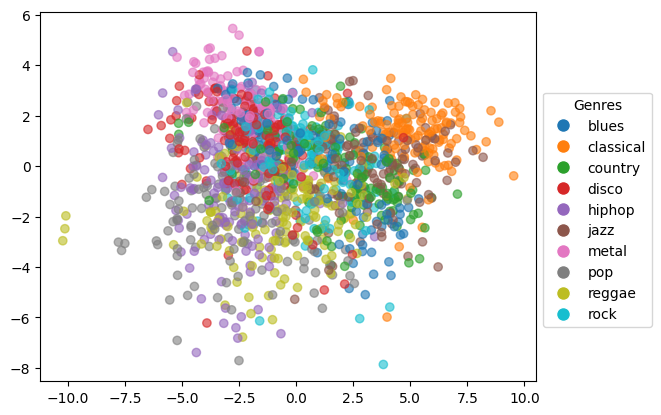

In [18]:
colormap = plt.colormaps['tab10']

plt.scatter(plot_Z[:1500,0], plot_Z[:1500,1], c=plot_y[:1500], cmap=colormap, alpha=0.6)

colours = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for color, label in zip(colormap(range(10)), np.unique(y))]

plt.legend(colours, np.unique(y), title="Genres", bbox_to_anchor=(1, .8))
plt.show()

It seems that the genres are not all completely mixed with one another, which means there is potential for good results on the classification task!